In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import sparse
import inference
import cluster
import generation
import graph_tool as gt
from graph_tool import inference as gtinference


%load_ext autoreload
%autoreload 2

In [8]:
# Matplotlib settings

basic_line_color = '#808080'
black = '#222222'
darkgray = '#A9A9A9'
highlight = '#00B2EE'

color0 = '#1f78b4'
color1 = '#b2df8a'
color2 = '#a6cee3'

plt.rc('figure', figsize=(8, 5))
plt.rc('font', size=32)
plt.rc('font', family='sans-serif')
plt.rcParams['font.sans-serif'] = 'verdana'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.edgecolor'] = basic_line_color
plt.rcParams['xtick.color'] = basic_line_color
plt.rcParams['ytick.color'] = basic_line_color
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['lines.markersize'] = 12

%config InlineBackend.figure_format = 'retina'

<ipython-input-3-1eb0a919246f>:4: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  clique = scipy.asmatrix(scipy.ones((nodes_per_clique,nodes_per_clique),dtype=int))
<ipython-input-3-1eb0a919246f>:4: DeprecationWarning: scipy.asmatrix is deprecated and will be removed in SciPy 2.0.0, use numpy.asmatrix instead
  clique = scipy.asmatrix(scipy.ones((nodes_per_clique,nodes_per_clique),dtype=int))


Text(-0.11, 1, 'A')

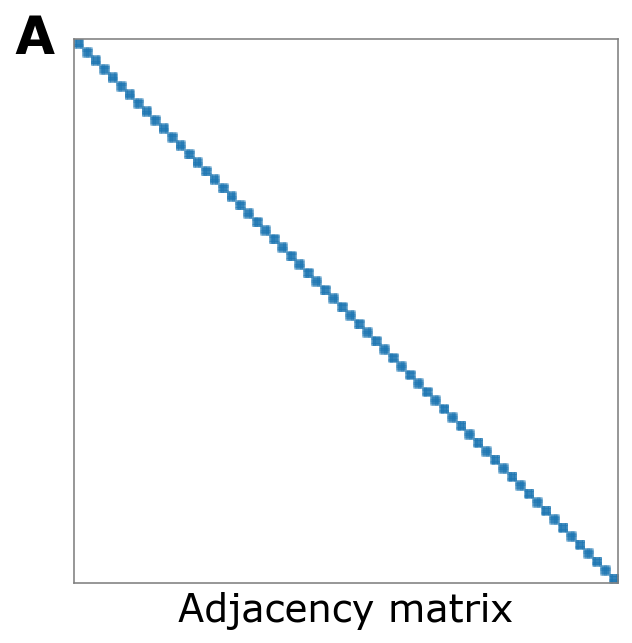

In [3]:
# build clique graph
n_cliques = 64
nodes_per_clique = 10
clique = scipy.asmatrix(scipy.ones((nodes_per_clique,nodes_per_clique),dtype=int))
A = clique
for i in range(n_cliques-1):
    A = scipy.sparse.block_diag((A,clique))
plt.figure()
ax = plt.gca()
plt.spy(A,ms=0.001, rasterized=True, color=color0)
plt.xticks([])
plt.yticks([])
plt.xlabel('Adjacency matrix')
ax.annotate('A', (-0.11, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

In [4]:
GT_graph = gt.Graph()
GT_graph.add_edge_list(scipy.transpose(A.nonzero()))
blockmodel_state = gtinference.minimize_nested_blockmodel_dl(GT_graph)
pvec = blockmodel_state.print_summary()

<ipython-input-4-08571e43b1c3>:2: DeprecationWarning: scipy.transpose is deprecated and will be removed in SciPy 2.0.0, use numpy.transpose instead
  GT_graph.add_edge_list(scipy.transpose(A.nonzero()))


l: 0, N: 640, B: 64
l: 1, N: 64, B: 30
l: 2, N: 30, B: 14
l: 3, N: 14, B: 7
l: 4, N: 7, B: 3
l: 5, N: 3, B: 2
l: 6, N: 2, B: 1


In [5]:
blockmodel_state.draw(output_size=(1600,1600), output="dendrogram_MDL.png")

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f1d50a8b730, at 0x7f1cd1128e80>,
 <Graph object, directed, with 761 vertices and 760 edges, at 0x7f1cd1123370>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f1cd1123370, at 0x7f1cd1124610>)

Text(-0.12, 1, 'C')

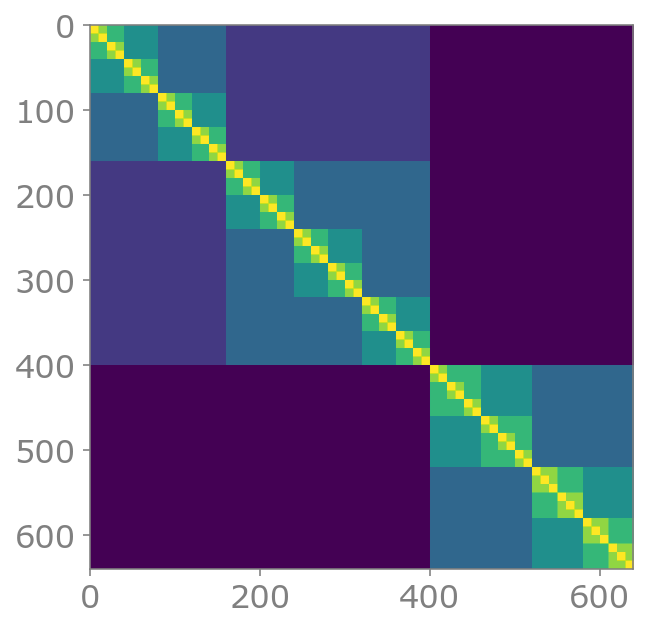

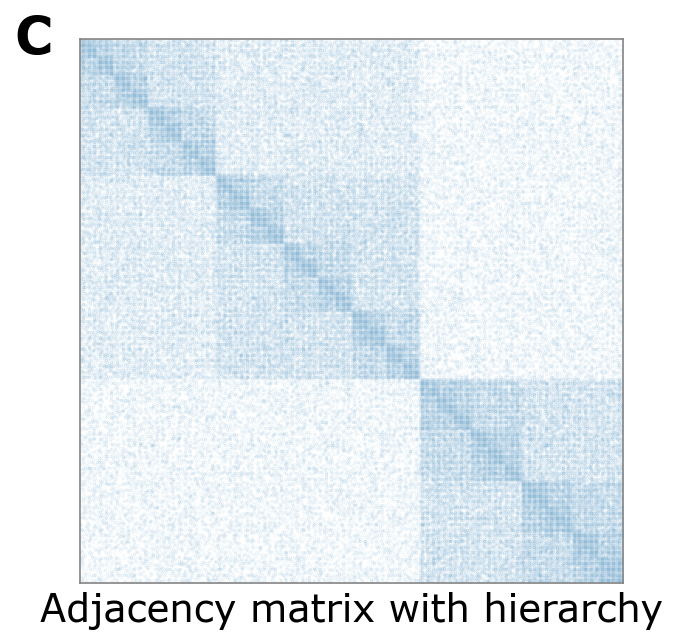

In [6]:
# read out partition from nested blockmodel and create a adjacency matrix with a hierarchy of that structure
pvec_list = blockmodel_state.get_state()
pvec_list_exp = []
omega = 0
H0 = np.eye(n_cliques*nodes_per_clique)
for pvec in pvec_list:
    part = cluster.Partition(pvec)
    H0 = H0 @ part.H    
    pvec_list_exp.append(np.nonzero(H0)[1])
    omega = omega + H0 @ H0.T
omega = omega / np.max(omega)
sorted_indices = np.lexsort(pvec_list_exp)

sorted_omega = omega[np.ix_(sorted_indices,sorted_indices)]
plt.imshow(sorted_omega)

Ahier = 1* np.random.rand(sorted_omega.shape[0],sorted_omega.shape[1]) <= sorted_omega
plt.figure()
ax= plt.gca()
plt.spy(Ahier,markersize=0.05, marker=".", color=color0, rasterized=True)
plt.xticks([])
plt.yticks([])
plt.xlabel('Adjacency matrix with hierarchy')
ax.annotate('C', (-0.12, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

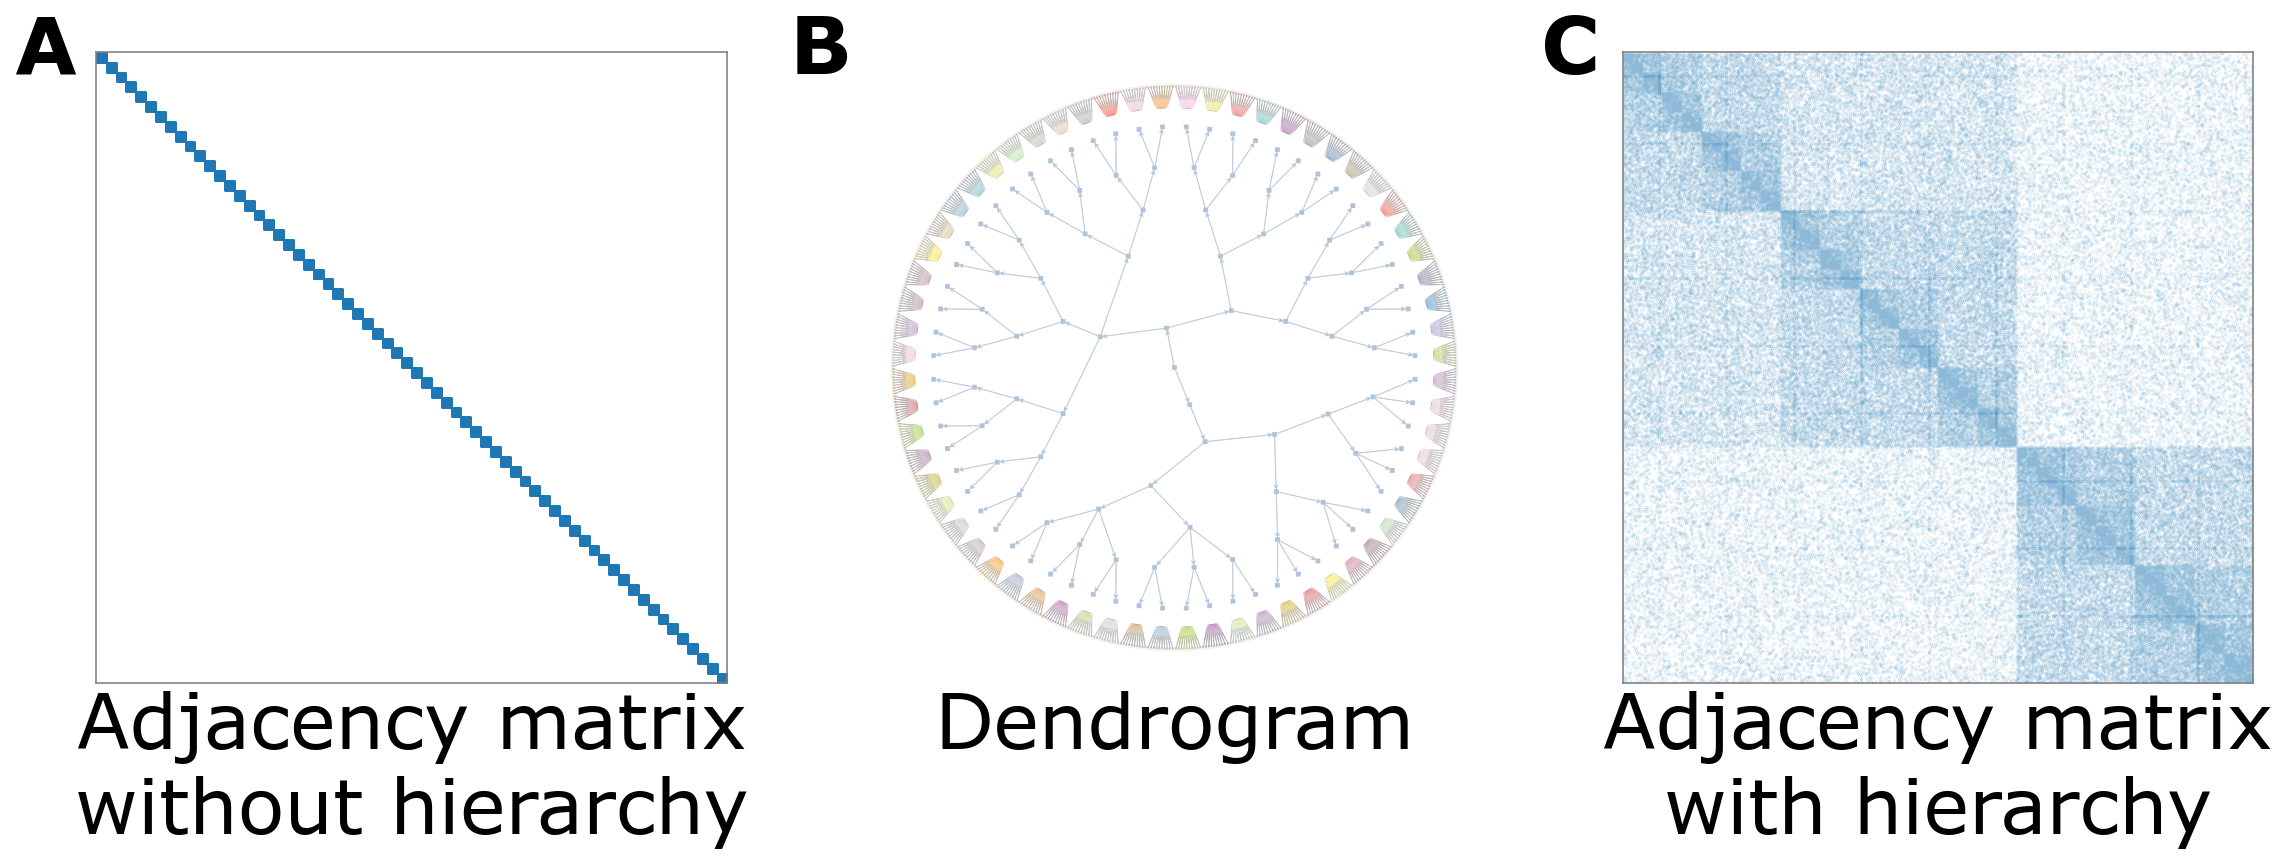

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

textsize = 40

ax = axs[0]

ax.spy(A, ms=1, marker=".", rasterized=True, color=color0)
ax.set(xticks=[], yticks=[], xlabel='Adjacency matrix\nwithout hierarchy')

ax.annotate('A', (-0.13, 1), xycoords='axes fraction', va='center', size=textsize, weight='bold')

ax = axs[1]
hierdata = plt.imread('dendrogram_MDL.png', format='png')
ax.imshow(hierdata, cmap="hot")
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xticks=[], yticks=[], xlabel='Dendrogram')

ax.annotate('B', (-0.11, 1), xycoords='axes fraction', va='center', size=textsize, weight='bold')

ax = axs[2]
ax.spy(Ahier,markersize=0.1, marker=".", color=color0, rasterized=True)
ax.set(xticks=[], yticks=[], xlabel='Adjacency matrix\nwith hierarchy')

ax.annotate('C', (-0.13, 1), xycoords='axes fraction', va='center', size=textsize, weight='bold')

plt.tight_layout(pad=0)
plt.savefig('Figure1-v2.pdf', dpi=150)